In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path(globals()['_dh'][0]).parent))

from pylegs.io import read_table
import matplotlib.pyplot as plt
from splusclusters.loaders import load_members_index_v6
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.units as u
from astromodule.distance import mpc2arcsec
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM

In [2]:
def plot_velocity(df_members, df_interlopers, r200, ax: plt.Axes, loc='best'):
  ax.scatter(df_members.radius_Mpc, df_members.v_offset, c='tab:red', edgecolor='k', lw=0.3, alpha=0.95, marker='o', s=15, label='Members', rasterized=True)  
  ax.scatter(df_interlopers.radius_Mpc, df_interlopers.v_offset, c='tab:blue', edgecolor='k', lw=0.3, alpha=0.95, marker='v', s=15, label='Interlopers', rasterized=True)
  ylim = ax.get_ylim()
  ax.vlines(r200, *ylim, color='k', alpha=0.65, lw=.9, label='R$_{{200}}$')
  ax.vlines(5*r200, *ylim, ls='--', color='k', alpha=0.65, lw=.9, label='5$\\times$R$_{{200}}$')
  # ax.text(r200, -1890, 'R$_{{200}}$',)
  # ax.text(5*r200, -1890, '5$\\times$R$_{{200}}$',)
  # ax.legend(loc=loc)
  ax.set_ylim(-2000, 2000)
  ax.set_xlim(min(df_members.radius_Mpc.min(), df_interlopers.radius_Mpc.min()) - 0.2, max(df_members.radius_Mpc.max(), df_interlopers.radius_Mpc.max()) + 0.2)
  ax.tick_params(direction='in', right=True, top=True)
  ax.set_xlabel('Distance (Mpc)')
  ax.set_ylabel('$\\Delta$v (km/s)')
  # ax.set_title('Spectroscoptic velocity x distance')
  return ax


def _add_circle(
  ra: float, 
  dec: float, 
  radius: float,
  color: str,
  ax,
  label: str = None,
  ls: str = '-',
  alpha: float = 1,
  lw: int = 2,
):
  circle = SphericalCircle(
    center=[ra, dec]*u.deg,
    radius=radius*u.deg,
    fc='none', 
    lw=lw, 
    linestyle=ls,
    ec=color, 
    alpha=alpha,
    transform=ax.get_transform('icrs'), 
    label=label,
  )
  ax.add_patch(circle)


def _add_all_circles(
  cls_ra: float,
  cls_dec: float,
  r200_deg: float,
  r200_Mpc: float,
  r500_deg: float,
  r500_Mpc: float,
  search_radius_deg: float,
  search_radius_Mpc: float,
  ax,
):
  if r200_deg:
    _add_circle(
      ra=cls_ra,
      dec=cls_dec,
      radius=r200_deg,
      color='k',
      alpha=0.75,
      lw=1,
      # label=f'R200 ({r200_Mpc:.2f}Mpc',
      ax=ax
    )
    _add_circle(
      ra=cls_ra,
      dec=cls_dec,
      radius=5*r200_deg,
      color='k',
      ls='--',
      alpha=0.75,
      lw=1,
      # label=f'5$\\times$R200 ({5*r200_Mpc:.2f}Mpc',
      ax=ax
    )
  if r500_deg:
    _add_circle(
      ra=cls_ra,
      dec=cls_dec,
      radius=5*r500_deg,
      color='tab:green',
      ls='--',
      # label=f'5$\\times$R500 ({5*r500_Mpc:.2f}Mpc $\\bullet$ {5*r500_deg:.2f}$^\\circ$)',
      ax=ax
    )
  if search_radius_deg and r200_deg and abs(search_radius_deg - r200_deg) > 0.1:
    _add_circle(
      ra=cls_ra,
      dec=cls_dec,
      radius=search_radius_deg,
      color='k',
      alpha=0.75,
      ls=':',
      lw=1.2,
      # label=f'{search_radius_Mpc:.2f}Mpc',
      ax=ax
    )


def _add_cluster_center(ra, dec, ax):
  ax.scatter(
    ra, 
    dec, 
    marker='x', 
    linewidths=1.5, 
    s=12, 
    c='k', 
    rasterized=True, 
    transform=ax.get_transform('icrs'),
  )


def plot_ra_dec(
  cls_ra, 
  cls_dec, 
  cls_r200_deg, 
  cls_r200_Mpc, 
  cls_r500_deg, 
  cls_r500_Mpc, 
  cls_search_radius_deg, 
  cls_search_radius_Mpc, 
  df_members,  
  df_interlopers, 
  ax: plt.Axes, 
  loc='best'
):
  l1 = ax.scatter(
    df_interlopers.ra, 
    df_interlopers.dec, 
    c='tab:blue', 
    marker='v',
    lw=0.2,
    ec=(0, 0, 0),
    s=15,
    alpha=0.95,
    # label=f'Interlopers ({len(df_interlopers)})', 
    transform=ax.get_transform('icrs'), 
    rasterized=True,
  )
  l2 = ax.scatter(
    df_members.ra, 
    df_members.dec, 
    c='tab:red', 
    lw=0.2,
    ec=(0, 0, 0),
    s=15,
    alpha=0.95,
    # label=f'Members ({len(df_members)})', 
    transform=ax.get_transform('icrs'), 
    rasterized=True,
  )
  _add_all_circles(
    cls_ra=cls_ra, 
    cls_dec=cls_dec, 
    r200_deg=cls_r200_deg, 
    r200_Mpc=cls_r200_Mpc, 
    r500_deg=cls_r500_deg, 
    r500_Mpc=cls_r500_Mpc, 
    search_radius_deg=cls_search_radius_deg,
    search_radius_Mpc=cls_search_radius_Mpc,
    ax=ax
  )
  _add_cluster_center(cls_ra, cls_dec, ax)
  ax.invert_xaxis()
  ax.set_aspect('equal', adjustable='datalim', anchor='C')
  ax.tick_params(direction='in')
  # ax.legend()
  ax.set_xlabel('Right Ascension (J2000)')
  ax.set_ylabel('Declination (J2000)')

31    1.040702
Name: R200_Mpc, dtype: float64


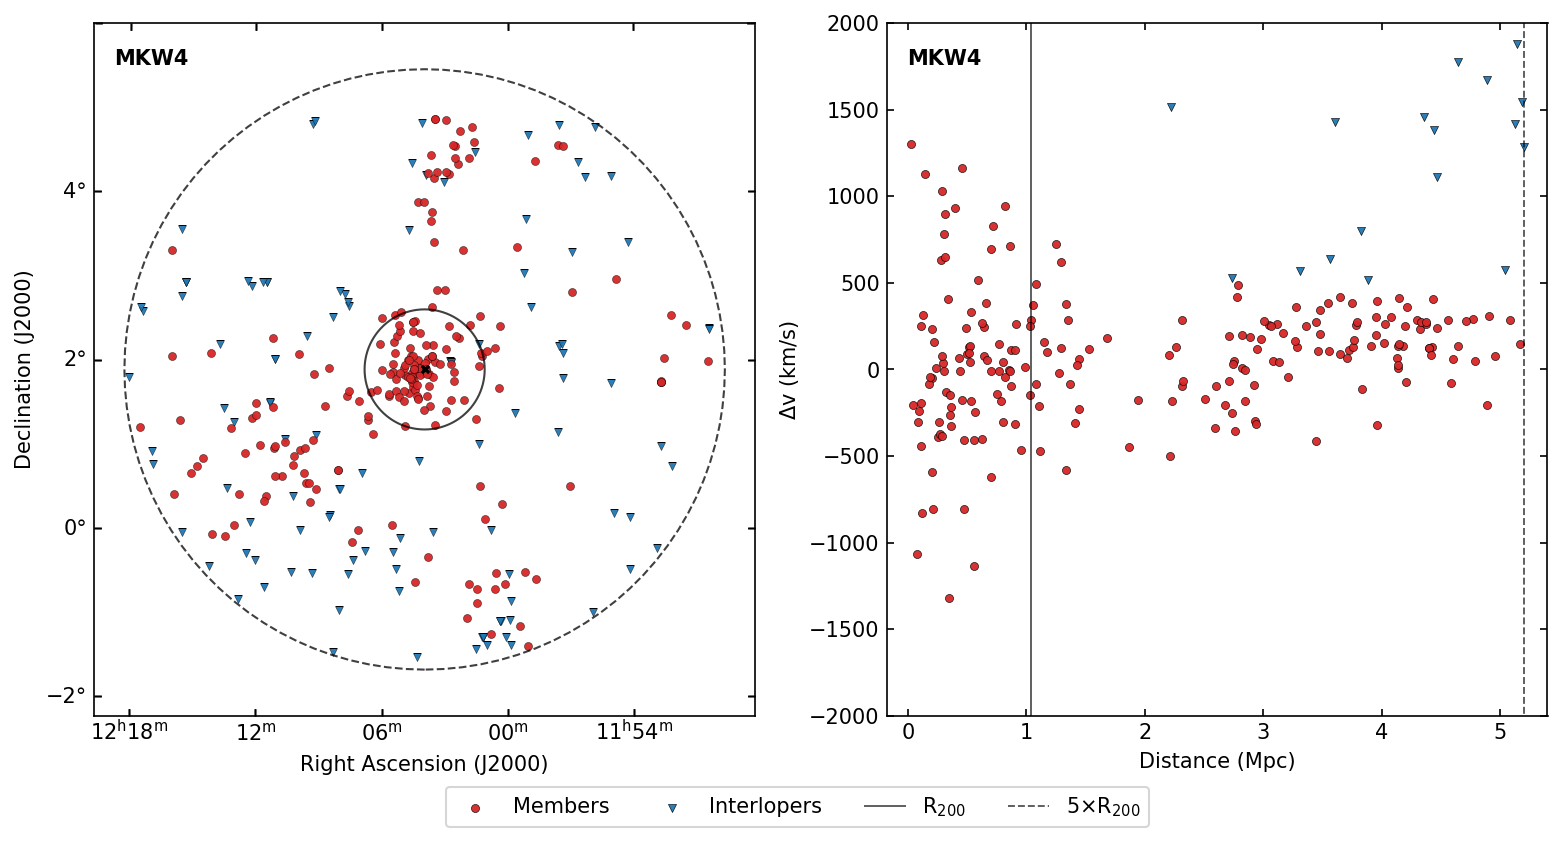

In [7]:
def plot_figs(cluster_name, dist_lim, search_radius = True):
  df = read_table(f'{cluster_name}.parquet')
  df = df[df.f_z.str.startswith('KEEP') & (df.radius_Mpc < dist_lim)]
  df_meta = load_members_index_v6()
  cluster = df_meta[df_meta.name == cluster_name]
  print(cluster.R200_Mpc)

  wcs_spec =  {
    # 'CDELT1': -1.0,
    # 'CDELT2': 1.0,
    # 'CRPIX1': 8.5,
    # 'CRPIX2': 8.5,
    'CRVAL1': cluster['ra'].values[0],
    'CRVAL2': cluster['dec'].values[0],
    'CTYPE1': 'RA---AIT',
    'CTYPE2': 'DEC--AIT',
    'CUNIT1': 'deg',
    'CUNIT2': 'deg'
  }
  wcs = WCS(wcs_spec)

  cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
  if search_radius:
    search_radius_deg = mpc2arcsec(dist_lim*u.Mpc, cluster['z_spec'].values[0], cosmo).to(u.deg).value
  else:
    search_radius_deg = None
  
  fig = plt.figure(figsize=(12.5, 6), dpi=150)
  ax = fig.add_subplot(121, projection=wcs)
  plot_ra_dec(
    cls_ra=cluster['ra'].values[0],
    cls_dec=cluster['dec'].values[0],
    cls_r200_deg=mpc2arcsec(cluster['R200_Mpc'].values[0]*u.Mpc, cluster['z_spec'].values[0], cosmo).to(u.deg).value, 
    cls_r200_Mpc=cluster['R200_Mpc'].values[0],
    cls_r500_deg=None,
    cls_r500_Mpc=None,
    cls_search_radius_deg=search_radius_deg,
    cls_search_radius_Mpc=None,
    df_members=df[df.flag_member == 0],
    df_interlopers=df[df.flag_member == 1],
    ax=ax,
  )
  ax.text(.03, .94, cluster_name, fontweight='bold', fontsize=10, transform=ax.transAxes)

  ax = fig.add_subplot(122)
  plot_velocity(df[df.flag_member == 0], df[df.flag_member == 1], cluster['R200_Mpc'].values[0], ax, loc='upper left')
  ax.text(.03, .94, cluster_name, fontweight='bold', fontsize=10, transform=ax.transAxes)
  
  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.025))
  plt.savefig(f'{cluster_name}.pdf', bbox_inches='tight', pad_inches=0.03)
  
  
plot_figs('MKW4', 5.2, False)
# plot_figs('A168', 10)